1. Preprocessing Routine
Objective: Implement a preprocessing pipeline to clean and standardize data, ensuring that both training and test data are processed the same way.
Implementation: Use tools like StandardScaler for normalization and SimpleImputer for handling missing values. Package this as a pipeline step in sklearn to maintain consistency across different stages.
2. Feature Selection and Dimensionality Reduction
Objective: Prioritize the most relevant features and potentially reduce the feature space for faster training.

Approach:

Permutation Testing: Test different feature subsets by dropping specific columns and evaluating changes in performance. Track changes in the F1 score for each subset to identify impactful features.
Dimensionality Reduction (PCA): Use PCA to further reduce dimensionality by retaining components that account for a significant portion of variance (e.g., 95%). This can accelerate model training by reducing noise and unimportant features.
Feature Importance from PCA: Evaluate which features contribute most to each principal component, based on eigenvalues. Discard features with minimal contributions to maintain a balance between performance and model complexity.

3. Model Training with XGBoost Classifier
Objective: Train the model using the optimized feature set from the previous step.
Pipeline Setup: Create a pipeline that includes the preprocessing, feature selection, and XGBoost model.
Hyperparameter Tuning with K-Fold Grid Search:
Use GridSearchCV to tune hyperparameters such as learning_rate, max_depth, n_estimators, and subsample.
Set scoring='f1' to prioritize the F1 score during optimization.
4. Evaluate the Impact of Feature Selection and Dimensionality Reduction
Objective: Determine whether feature reduction has improved, degraded, or maintained model performance.
Comparison: After finding the optimal hyperparameters, compare F1 scores from models trained with full features versus reduced features (via permutation tests and PCA) to confirm the benefits of feature selection.
5. Latent Space Embedding Projection (Optional)
Objective: Further understand the data structure by projecting it into a latent space for analysis.
Techniques: Use t-SNE, UMAP, or autoencoders to create embeddings that could reveal additional patterns or relationships, potentially informing new feature engineering strategies.
6. Neural Network Exploration (Optional)
Objective: Explore neural networks as an alternative to XGBoost for this task.
Implementation:
Replace XGBoost with a neural network architecture, varying parameters like layer count, activation functions, learning rate, and batch size.
Use GridSearchCV for tuning and evaluation, focusing on the F1 score to match previous results.
Comparison: Evaluate neural network performance relative to XGBoost in terms of F1 score and computational efficiency.


In [1]:
!pip install category-encoders==2.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# next step could be to take the preprocessing from the first notebook to this one

# test_clean_df = pd.read_csv('test_clean_df.csv')
train_clean_df = pd.read_csv('cleaned_dataset.csv')

<ipython-input-34-fd11661e9da7>:11: DtypeWarning: Columns (29,50) have mixed types. Specify dtype option on import or set low_memory=False.
  train_clean_df = pd.read_csv('cleaned_dataset.csv')


In [35]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0,2019-08,2019Q3,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,2020-01,2020Q1,2020.0,2020-02,2020Q1,2020.0,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2020-01,2020Q1,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01,2020Q1,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0,2019-12,2019Q4,2019.0,2020-01,2020Q1,2020,2019-12,2019Q4,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12,2022Q4,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
593467,

In [36]:
train_clean_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Accident Date_Month', 'Accident Date_Quarter', 'Accident Date_Year',
       'Assembly Date_Month', 'Assembly Date_Quarter', 'Assembly Date_Year',
       'C-2 Date_Month', 'C-2 Date_Quarter', 'C

In [37]:
missing_percentage = (train_clean_df.isnull().sum() / len(train_clean_df)) * 100

print(missing_percentage)

Accident Date                                  3.898084
Age at Injury                                  4.282265
Alternative Dispute Resolution                 3.276487
Assembly Date                                  0.000000
Attorney/Representative                        3.276487
Average Weekly Wage                            8.104187
Birth Year                                    12.432789
C-2 Date                                       5.729850
C-3 Date                                      68.449174
Carrier Name                                   3.276487
Carrier Type                                   3.276487
Claim Identifier                               0.000000
Claim Injury Type                              3.276487
County of Injury                               3.276487
COVID-19 Indicator                             3.276487
District Name                                  3.276487
First Hearing Date                            74.590502
Gender                                         3

In [38]:
# exclude colls definition
exclude_cols = [
    'Zip Code',
    'OIICS Nature of Injury Description',
    'IME-4 Count',
    'First Hearing Date_Year',
    'First Hearing Date_Quarter',
    'First Hearing Date_Month',
    'First Hearing Date',
    'C-3 Date_Year',
    'C-3 Date',
    'C-3 Date_Quarter',
    'C-3 Date_Month',
    'Alternative Dispute Resolution',
    'WCIO Nature of Injury Code',
    'WCIO Nature of Injury Description',
    'Gender',
    'WCIO Cause of Injury Description',
    'Industry Code Description',
    'County of Injury',
    'Carrier Name',
    'Accident Date_Month',	'Accident Date_Quarter',	'Accident Date_Year' ,	'Assembly Date_Month',	'Assembly Date_Quarter'	,'Assembly Date_Year',	'C-2 Date_Month',	'C-2 Date_Quarter',	'C-2 Date_Year'
]

#claim injury identifier before testing, and agreement reached



In [39]:
numerical_features = train_clean_df.select_dtypes(include=np.number).columns
categorical_features = train_clean_df.select_dtypes(exclude=np.number).columns

for feature in numerical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mean())

for feature in categorical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mode()[0])

In [40]:
train_dropped_df = train_clean_df.copy()

columns_to_drop = exclude_cols

train_dropped_df = train_dropped_df.drop(columns=columns_to_drop)



In [41]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Accident Date_Month,Accident Date_Quarter,Accident Date_Year,Assembly Date_Month,Assembly Date_Quarter,Assembly Date_Year,C-2 Date_Month,C-2 Date_Quarter,C-2 Date_Year,C-3 Date_Month,C-3 Date_Quarter,C-3 Date_Year,First Hearing Date_Month,First Hearing Date_Quarter,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.00000,N,2020-01-01,N,0.000000,1988.000000,2019-12-31,2021-04-21,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,2022-04-15,M,3.110657,44.000000,RETAIL TRADE,I,NaN,27.000000,FROM LIQUID OR GREASE SPILLS,10.000000,CONTUSION,62.000000,BUTTOCKS,13662,0.000000,Not Work Related,1.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2019-12,2019Q4,2019.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.00000,N,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.000000,23.000000,CONSTRUCTION,I,NaN,97.000000,REPETITIVE MOTION,49.000000,SPRAIN OR TEAR,38.000000,SHOULDER(S),14569,1.000000,Not Work Related,4.000000,2019-08,2019Q3,2019.000000,2020-01,2020Q1,2020,2020-01,2020Q1,2020.000000,2020-01,2020Q1,2020.000000,2020-02,2020Q1,2020.000000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.00000,N,2020-01-01,N,1434.800000,1979.000000,2020-01-01,2021-04-21,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,2022-04-15,M,3.110657,56.000000,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.000000,OBJECT BEING LIFTED OR HANDLED,7.000000,CONCUSSION,10.000000,MULTIPLE HEAD INJURY,12589,0.000000,Not Work Related,6.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2020-01,2020Q1,2020.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-03-01,42.50377,N,2020-01-01,N,491.088321,1977.815483,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,957648180,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,3.110657,58.645305,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,54.381143,LIFTING,41.013839,STRAIN OR TEAR,43.714466,LOWER BACK AREA,11236,0.046665,Not Work Related,3.006559,2020-03,2020Q1,2020.827849,2020-01,2020Q1,2020,2022-08,2022Q3,2021.044907,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.00000,N,2020-01-01,N,491.088321,1958.000000,2019-12-31,2021-04-21,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,2022-04-15,M,3.110657,62.000000,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.000000,"HAND TOOL, UTENSIL; NOT POWERED",43.000000,PUNCTURE,36.000000,FINGER(S),12603,0.000000,Not Work Related,1.000000,2019-12,2019Q4,2019.000000,2020-01,2020Q1,2020,2019-12,2019Q4,2019.000000,2021-03,2021Q2,2021.075431,2023-03,2021Q4,2021.719552,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASS

In [42]:
pd.set_option('display.max_columns', None)
train_dropped_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,Claim Injury Type,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.00000,2020-01-01,N,0.000000,1988.000000,2019-12-31,1A. PRIVATE,5393875,2. NON-COMP,N,SYRACUSE,44.000000,I,27.000000,62.000000,BUTTOCKS,0.000000,Not Work Related,1.000000,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.00000,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,1A. PRIVATE,5393091,4. TEMPORARY,N,ROCHESTER,23.000000,I,97.000000,38.000000,SHOULDER(S),1.000000,Not Work Related,4.000000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.00000,2020-01-01,N,1434.800000,1979.000000,2020-01-01,1A. PRIVATE,5393889,4. TEMPORARY,N,ALBANY,56.000000,II,79.000000,10.000000,MULTIPLE HEAD INJURY,0.000000,Not Work Related,6.000000,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-03-01,42.50377,2020-01-01,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,957648180,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.00000,2020-01-01,N,491.088321,1958.000000,2019-12-31,2A. SIF,5393887,2. NON-COMP,N,ALBANY,62.000000,II,16.000000,36.000000,FINGER(S),0.000000,Not Work Related,1.000000,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,327160035,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
593467,2022-12-13,72.00000,2022-12-31,N,0.000000,1950.000000,2022-12-31,1A. PRIVATE,6165075,2. NON-COMP,N,BINGHAMTON,48.000000,I,25.000000,43.714466,MULTIPLE,0.000000,Not Work Related,3.000000,OTHER_CARRIERS,OTHER_COUNTIES,127,TRANSPORTATION AND WAREHOUSING,FROM DIFFERENT LEVEL (ELEVATION),MULTIPLE PHYSICAL INJURIES ONLY,MULTIPLE,F,N
593468,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,249875936,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
593469,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,120584215,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N


In [43]:


for col in train_dropped_df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}:")
    print(train_dropped_df[col].value_counts(normalize=True).multiply(100).round(2))


Accident Date:
Accident Date
2020-03-01    4.11
2020-12-18    0.17
2022-02-07    0.16
2022-01-05    0.15
2021-02-18    0.14
              ... 
2017-05-17    0.00
2015-05-28    0.00
2002-08-18    0.00
2017-09-01    0.00
1980-05-17    0.00
Name: proportion, Length: 5539, dtype: float64

Assembly Date:
Assembly Date
2020-03-06    0.24
2021-05-11    0.23
2022-04-01    0.21
2022-02-04    0.21
2022-08-15    0.20
              ... 
2022-07-31    0.00
2021-12-19    0.00
2020-08-23    0.00
2020-07-04    0.00
2022-05-08    0.00
Name: proportion, Length: 1096, dtype: float64

Attorney/Representative:
Attorney/Representative
N    69.38
Y    30.62
Name: proportion, dtype: float64

C-2 Date:
C-2 Date
2021-05-11    6.04
2020-03-05    0.23
2021-05-27    0.21
2022-08-15    0.19
2021-06-22    0.18
              ... 
2006-06-26    0.00
1998-10-30    0.00
2004-03-03    0.00
2011-12-29    0.00
2024-01-19    0.00
Name: proportion, Length: 2475, dtype: float64

Carrier Type:
Carrier Type
1A. PRIVATE        

In [44]:
import pandas as pd
import numpy as np

def safe_bin(series, bins=10):
    """
    Safely bin a series using cut instead of qcut
    """
    clean_series = pd.to_numeric(series, errors='coerce')
    clean_series = clean_series.dropna()

    if len(clean_series) == 0:
        return pd.Series(index=series.index)

    min_val = clean_series.min()
    max_val = clean_series.max()

    if min_val == max_val:
        return pd.Series('Bin_1', index=series.index)

    bin_edges = np.linspace(min_val, max_val, bins + 1)
    labels = [f'Bin_{i+1}' for i in range(bins)]

    try:
        binned = pd.cut(clean_series,
                       bins=bin_edges,
                       labels=labels,
                       include_lowest=True)
        return binned
    except Exception as e:
        print(f"Binning error for values between {min_val} and {max_val}: {str(e)}")
        return series

def create_binned_df(df):
    """
    Create a new dataframe with only binned columns
    """
    df_new = pd.DataFrame(index=df.index)

    # Date variables binning
    date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date']
    for col in date_columns:
        try:
            dates = pd.to_datetime(df[col], errors='coerce')
            timestamps = dates.astype(np.int64)
            df_new[f'{col}_binned'] = safe_bin(timestamps)
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Numeric columns binning
    numeric_columns = [
        'Age at Injury',
        'Birth Year',
        'Average Weekly Wage',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Part Of Body Code',
        'Number of Dependents',
        'Agreement Reached'
    ]

    for col in numeric_columns:
        try:
            df_new[f'{col}_binned'] = safe_bin(df[col])
        except Exception as e:
            print(f"Warning: Could not bin {col}: {str(e)}")

    # Zip Region binning
    try:
        zip_values = pd.to_numeric(df['Zip_Region'].astype(str).str.extract('(\d+)')[0],
                                 errors='coerce')
        df_new['Zip_Region_binned'] = safe_bin(zip_values)
    except Exception as e:
        print(f"Warning: Could not bin Zip_Region: {str(e)}")

    return df_new

# Create new dataframe with only binned columns
binned_only_df = create_binned_df(train_dropped_df)

# Print info about the new dataframe
print("\nNew dataframe info:")
print(f"Shape: {binned_only_df.shape}")
print("\nColumns:")
for col in binned_only_df.columns:
    print(f"- {col}")

# Print sample of the data
print("\nSample of binned data:")
print(binned_only_df.head())

# Print value counts for each column
print("\nValue counts for each column:")
for col in binned_only_df.columns:
    print(f"\n{col}:")
    print(binned_only_df[col].value_counts().sort_index())


New dataframe info:
Shape: (593471, 12)

Columns:
- Accident Date_binned
- Assembly Date_binned
- C-2 Date_binned
- Age at Injury_binned
- Birth Year_binned
- Average Weekly Wage_binned
- Industry Code_binned
- WCIO Cause of Injury Code_binned
- WCIO Part Of Body Code_binned
- Number of Dependents_binned
- Agreement Reached_binned
- Zip_Region_binned

Sample of binned data:
  Accident Date_binned Assembly Date_binned C-2 Date_binned  \
0               Bin_10                Bin_1           Bin_9   
1               Bin_10                Bin_1           Bin_9   
2               Bin_10                Bin_1           Bin_9   
3               Bin_10                Bin_1           Bin_9   
4               Bin_10                Bin_1           Bin_9   

  Age at Injury_binned Birth Year_binned Average Weekly Wage_binned  \
0                Bin_3             Bin_8                      Bin_1   
1                Bin_5             Bin_6                      Bin_1   
2                Bin_4        

In [45]:
binned_only_df

,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Age at Injury_binned,Birth Year_binned,Average Weekly Wage_binned,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,Agreement Reached_binned,Zip_Region_binned
0,Bin_10,Bin_1,Bin_9,Bin_3,Bin_8,Bin_1,Bin_5,Bin_3,Bin_6,Bin_2,Bin_1,Bin_2
1,Bin_10,Bin_1,Bin_9,Bin_5,Bin_6,Bin_1,Bin_2,Bin_10,Bin_4,Bin_7,Bin_10,Bin_2
2,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_8,Bin_1,Bin_10,Bin_1,Bin_2
3,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
4,Bin_10,Bin_1,Bin_9,Bin_7,Bin_5,Bin_1,Bin_7,Bin_2,Bin_3,Bin_2,Bin_1,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593467,Bin_10,Bin_10,Bin_10,Bin_9,Bin_4,Bin_1,Bin_5,Bin_3,Bin_4,Bin_5,Bin_1,Bin_2
593468,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593469,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2


In [46]:
# Create a new DataFrame called 'modified_df'
modified_df = train_dropped_df[[col for col in train_dropped_df.columns if not col.endswith('_Grouped')]]

# Add columns from binned_only_df to 'modified_df'
modified_df = pd.concat([modified_df, binned_only_df], axis=1)

In [47]:
modified_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,Claim Injury Type,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,Zip_Region,Gender_Clean,ADR_Clean,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Age at Injury_binned,Birth Year_binned,Average Weekly Wage_binned,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Number of Dependents_binned,Agreement Reached_binned,Zip_Region_binned
0,2019-12-30,31.00000,2020-01-01,N,0.000000,1988.000000,2019-12-31,1A. PRIVATE,5393875,2. NON-COMP,N,SYRACUSE,44.000000,I,27.000000,62.000000,BUTTOCKS,0.000000,Not Work Related,1.000000,NEW HAMPSHIRE INSURANCE CO,136,M,N,Bin_10,Bin_1,Bin_9,Bin_3,Bin_8,Bin_1,Bin_5,Bin_3,Bin_6,Bin_2,Bin_1,Bin_2
1,2019-08-30,46.00000,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,1A. PRIVATE,5393091,4. TEMPORARY,N,ROCHESTER,23.000000,I,97.000000,38.000000,SHOULDER(S),1.000000,Not Work Related,4.000000,OTHER_CARRIERS,145,F,N,Bin_10,Bin_1,Bin_9,Bin_5,Bin_6,Bin_1,Bin_2,Bin_10,Bin_4,Bin_7,Bin_10,Bin_2
2,2019-12-06,40.00000,2020-01-01,N,1434.800000,1979.000000,2020-01-01,1A. PRIVATE,5393889,4. TEMPORARY,N,ALBANY,56.000000,II,79.000000,10.000000,MULTIPLE HEAD INJURY,0.000000,Not Work Related,6.000000,INDEMNITY INSURANCE CO OF,125,M,N,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_8,Bin_1,Bin_10,Bin_1,Bin_2
3,2020-03-01,42.50377,2020-01-01,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,957648180,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,117,M,N,Bin_10,Bin_1,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
4,2019-12-30,61.00000,2020-01-01,N,491.088321,1958.000000,2019-12-31,2A. SIF,5393887,2. NON-COMP,N,ALBANY,62.000000,II,16.000000,36.000000,FINGER(S),0.000000,Not Work Related,1.000000,STATE INSURANCE FUND,126,M,N,Bin_10,Bin_1,Bin_9,Bin_7,Bin_5,Bin_1,Bin_7,Bin_2,Bin_3,Bin_2,Bin_1,Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,327160035,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,117,M,N,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593467,2022-12-13,72.00000,2022-12-31,N,0.000000,1950.000000,2022-12-31,1A. PRIVATE,6165075,2. NON-COMP,N,BINGHAMTON,48.000000,I,25.000000,43.714466,MULTIPLE,0.000000,Not Work Related,3.000000,OTHER_CARRIERS,127,F,N,Bin_10,Bin_10,Bin_10,Bin_9,Bin_4,Bin_1,Bin_5,Bin_3,Bin_4,Bin_5,Bin_1,Bin_2
593468,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,249875936,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,117,M,N,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2
593469,2020-03-01,42.50377,2022-12-31,N,491.088321,1977.815483,2021-05-11,1A. PRIVATE,120584215,2. NON-COMP,N,NYC,58.645305,IV,54.381143,43.714466,LOWER BACK AREA,0.046665,Not Work Related,3.006559,OTHER_CARRIERS,117,M,N,Bin_10,Bin_10,Bin_9,Bin_4,Bin_7,Bin_1,Bin_6,Bin_6,Bin_4,Bin_6,Bin_1,Bin_2


In [48]:
import pandas as pd
import numpy as np

def bin_categorical(series):
    """
    Bin categorical variables into 5 roughly equal-sized groups based on cumulative proportions
    """
    # Get value counts and calculate cumulative proportions
    value_counts = series.value_counts(normalize=True).cumsum()
    bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['Cat_Bin_1', 'Cat_Bin_2', 'Cat_Bin_3', 'Cat_Bin_4', 'Cat_Bin_5']

    # Create mapping dictionary for original values to bins
    bin_mapping = {}
    for value, cum_prop in value_counts.items():
        for i, (edge1, edge2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
            if cum_prop <= edge2:
                bin_mapping[value] = bin_labels[i]
                break

    return series.map(bin_mapping)

def process_grouped_columns(df):
    """
    Bin grouped columns and drop originals
    """
    # Create a copy of the dataframe
    processed_df = df.copy()

    # Find all columns with '_Grouped' in the name
    grouped_columns = [col for col in df.columns if '_Grouped' in col]

    # Bin each grouped column and add to dataframe
    for col in grouped_columns:
        processed_df[f'{col}_binned'] = bin_categorical(df[col])

        # Print distribution information
        print(f"\nBinning distribution for {col}:")
        dist = processed_df[f'{col}_binned'].value_counts().sort_index()
        total = len(processed_df)
        for bin_name, count in dist.items():
            percentage = (count / total) * 100
            print(f"{bin_name}: {count} ({percentage:.2f}%)")

    # Drop original grouped columns
    processed_df = processed_df.drop(columns=grouped_columns)

    return processed_df

# Process the dataframe
processed_df = process_grouped_columns(train_dropped_df)

# Print information about the changes
print("\nOriginal shape:", train_dropped_df.shape)
print("New shape:", processed_df.shape)

# Print columns that were dropped
dropped_cols = set(train_dropped_df.columns) - set(processed_df.columns)
print("\nDropped columns:")
for col in sorted(dropped_cols):
    print(f"- {col}")

# Print new binned columns
new_cols = set(processed_df.columns) - (set(train_dropped_df.columns) - set(dropped_cols))
print("\nNew binned columns:")
for col in sorted(new_cols):
    print(f"- {col}")

# Print sample of the new data
print("\nSample of processed data (first 5 rows of new binned columns):")
print(processed_df[sorted(new_cols)].head())


Binning distribution for County_Grouped:
Cat_Bin_1: 112655 (18.98%)
Cat_Bin_2: 118763 (20.01%)
Cat_Bin_3: 96787 (16.31%)
Cat_Bin_4: 126260 (21.27%)
Cat_Bin_5: 139006 (23.42%)

Binning distribution for Industry_Grouped:
Cat_Bin_1: 114339 (19.27%)
Cat_Bin_2: 92240 (15.54%)
Cat_Bin_3: 115661 (19.49%)
Cat_Bin_4: 149298 (25.16%)
Cat_Bin_5: 121933 (20.55%)

Binning distribution for WCIO Cause of Injury Description_Grouped:
Cat_Bin_1: 117643 (19.82%)
Cat_Bin_2: 116955 (19.71%)
Cat_Bin_3: 112988 (19.04%)
Cat_Bin_4: 124313 (20.95%)
Cat_Bin_5: 121572 (20.48%)

Binning distribution for WCIO Nature of Injury Description_Grouped:
Cat_Bin_2: 153373 (25.84%)
Cat_Bin_3: 183340 (30.89%)
Cat_Bin_4: 102946 (17.35%)
Cat_Bin_5: 147945 (24.93%)

Binning distribution for WCIO Part Of Body Description_Grouped:
Cat_Bin_1: 91990 (15.50%)
Cat_Bin_2: 141776 (23.89%)
Cat_Bin_3: 105292 (17.74%)
Cat_Bin_4: 134126 (22.60%)
Cat_Bin_5: 120287 (20.27%)

Original shape: (593471, 29)
New shape: (593471, 29)

Dropped colu

In [49]:
processed_df + binned_only_df

TypeError: Object with dtype category cannot perform the numpy op add

In [50]:
# Concatenate the dataframes
combined_df = pd.concat([processed_df, binned_only_df], axis=1)

# List of columns to keep (only binned and Claim Injury Type)
columns_to_keep = [
    'Age at Injury_binned', 'Average Weekly Wage_binned', 'Birth Year_binned',
    'Claim Identifier', 'Industry Code_binned', 'WCIO Cause of Injury Code_binned',
    'WCIO Part Of Body Code_binned', 'Agreement Reached_binned',
    'Number of Dependents_binned', 'County_Grouped_binned', 'Industry_Grouped_binned',
    'WCIO Cause of Injury Description_Grouped_binned',
    'WCIO Nature of Injury Description_Grouped_binned',
    'WCIO Part Of Body Description_Grouped_binned', 'Accident Date_binned',
    'Assembly Date_binned', 'C-2 Date_binned', 'Zip_Region_binned', 'Claim Injury Type'
]

# Add Claim Injury Type if it's not already in the combined dataframe
if 'Claim Injury Type' not in combined_df.columns:
    combined_df = pd.merge(
        combined_df,
        train_dropped_df[['Claim Identifier', 'Claim Injury Type']],
        on='Claim Identifier',
        how='left'
    )

# Keep only the specified columns
final_df = combined_df[columns_to_keep]

In [51]:
final_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Agreement Reached_binned,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned,Claim Injury Type
0,Bin_3,Bin_1,Bin_8,5393875,Bin_5,Bin_3,Bin_6,Bin_1,Bin_2,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
1,Bin_5,Bin_1,Bin_6,5393091,Bin_2,Bin_10,Bin_4,Bin_10,Bin_7,Cat_Bin_1,Cat_Bin_4,Cat_Bin_4,Cat_Bin_4,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
2,Bin_4,Bin_1,Bin_7,5393889,Bin_6,Bin_8,Bin_1,Bin_1,Bin_10,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Cat_Bin_3,Cat_Bin_5,Bin_10,Bin_1,Bin_9,Bin_2,4. TEMPORARY
3,Bin_4,Bin_1,Bin_7,957648180,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
4,Bin_7,Bin_1,Bin_5,5393887,Bin_7,Bin_2,Bin_3,Bin_1,Bin_2,Cat_Bin_5,Cat_Bin_1,Cat_Bin_5,Cat_Bin_5,Cat_Bin_3,Bin_10,Bin_1,Bin_9,Bin_2,2. NON-COMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,Bin_4,Bin_1,Bin_7,327160035,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593467,Bin_9,Bin_1,Bin_4,6165075,Bin_5,Bin_3,Bin_4,Bin_1,Bin_5,Cat_Bin_1,Cat_Bin_3,Cat_Bin_5,Cat_Bin_5,Cat_Bin_2,Bin_10,Bin_10,Bin_10,Bin_2,2. NON-COMP
593468,Bin_4,Bin_1,Bin_7,249875936,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP
593469,Bin_4,Bin_1,Bin_7,120584215,Bin_6,Bin_6,Bin_4,Bin_1,Bin_6,Cat_Bin_1,Cat_Bin_4,Cat_Bin_1,Cat_Bin_3,Cat_Bin_1,Bin_10,Bin_10,Bin_9,Bin_2,2. NON-COMP


In [54]:
import pandas as pd
import numpy as np

def encode_bins(df):
    """
    Encode all binned columns to numeric values, handling both regular bins and category dtype
    """
    encoded_df = df.copy()

    # Function to extract number from bin string
    def extract_bin_number(x):
        if pd.isna(x):
            return x
        try:
            if 'Cat_Bin_' in str(x):
                return int(str(x).split('Cat_Bin_')[1])
            elif 'Bin_' in str(x):
                return int(str(x).split('Bin_')[1])
            return x
        except:
            return x

    # Process each column
    for col in encoded_df.columns:
        if col == 'Claim Identifier':  # Skip the identifier column
            continue

        if encoded_df[col].dtype == 'category' or encoded_df[col].dtype == 'object':
            if 'Bin_' in str(encoded_df[col].iloc[0]) or 'Cat_Bin_' in str(encoded_df[col].iloc[0]):
                encoded_df[col] = encoded_df[col].astype(str).apply(extract_bin_number).astype(float)
                print(f"Encoded {col}: {sorted(encoded_df[col].unique())}")

    # Convert Claim Injury Type to numeric if it hasn't been converted yet
    if 'Claim Injury Type' in encoded_df.columns and encoded_df['Claim Injury Type'].dtype != 'int64':
        claim_type_mapping = {
            '1. CANCELLED': 1,
            '2. NON-COMP': 2,
            '3. MED ONLY': 3,
            '4. TEMPORARY': 4,
            '5. PPD SCH LOSS': 5,
            '6. PPD NSL': 6,
            '7. PTD': 7,
            '8. DEATH': 8
        }
        encoded_df['Claim Injury Type'] = encoded_df['Claim Injury Type'].map(claim_type_mapping)
        print(f"\nEncoded Claim Injury Type: {sorted(encoded_df['Claim Injury Type'].unique())}")

    # Print summary of the encoding
    print("\nEncoding Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Encoded shape: {encoded_df.shape}")

    # Display data types after encoding
    print("\nData Types After Encoding:")
    print(encoded_df.dtypes)

    # Display value ranges
    print("\nValue Ranges for Each Column:")
    for col in encoded_df.columns:
        if encoded_df[col].dtype in ['int64', 'float64']:
            print(f"{col}: {encoded_df[col].min()} to {encoded_df[col].max()}")

    # Verify all columns are numeric
    non_numeric = encoded_df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nWarning: The following columns are still non-numeric:")
        print(non_numeric.tolist())
    else:
        print("\nAll columns successfully converted to numeric format")

    return encoded_df

# Apply encoding to final_df
encoded_df = encode_bins(final_df)

# Display sample of encoded data
print("\nSample of encoded data (first 5 rows):")
print(encoded_df.head())

Encoded Age at Injury_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Average Weekly Wage_binned: [1.0, 2.0, 4.0, 5.0, 10.0]
Encoded Birth Year_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded Industry Code_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded WCIO Cause of Injury Code_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Encoded WCIO Part Of Body Code_binned: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0]
Encoded Agreement Reached_binned: [1.0, 10.0]
Encoded Number of Dependents_binned: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0]
Encoded County_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Industry_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Cause of Injury Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded WCIO Nature of Injury Description_Grouped_binned: [2.0, 3.0, 4.0, 5.0, nan]
Encoded WCIO Part Of Body Description_Grouped_binned: [1.0, 2.0, 3.0, 4.0, 5.0]
Encoded Accident Date_binn

In [55]:
encoded_df

,Age at Injury_binned,Average Weekly Wage_binned,Birth Year_binned,Claim Identifier,Industry Code_binned,WCIO Cause of Injury Code_binned,WCIO Part Of Body Code_binned,Agreement Reached_binned,Number of Dependents_binned,County_Grouped_binned,Industry_Grouped_binned,WCIO Cause of Injury Description_Grouped_binned,WCIO Nature of Injury Description_Grouped_binned,WCIO Part Of Body Description_Grouped_binned,Accident Date_binned,Assembly Date_binned,C-2 Date_binned,Zip_Region_binned,Claim Injury Type
0,3.0,1.0,8.0,5393875,5.0,3.0,6.0,1.0,2.0,1.0,3.0,5.0,3.0,1.0,10.0,1.0,9.0,2.0,2
1,5.0,1.0,6.0,5393091,2.0,10.0,4.0,10.0,7.0,1.0,4.0,4.0,4.0,3.0,10.0,1.0,9.0,2.0,4
2,4.0,1.0,7.0,5393889,6.0,8.0,1.0,1.0,10.0,5.0,5.0,3.0,3.0,5.0,10.0,1.0,9.0,2.0,4
3,4.0,1.0,7.0,957648180,6.0,6.0,4.0,1.0,6.0,1.0,4.0,1.0,3.0,1.0,10.0,1.0,9.0,2.0,2
4,7.0,1.0,5.0,5393887,7.0,2.0,3.0,1.0,2.0,5.0,1.0,5.0,5.0,3.0,10.0,1.0,9.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,4.0,1.0,7.0,327160035,6.0,6.0,4.0,1.0,6.0,1.0,4.0,1.0,3.0,1.0,10.0,10.0,9.0,2.0,2
593467,9.0,1.0,4.0,6165075,5.0,3.0,4.0,1.0,5.0,1.0,3.0,5.0,5.0,2.0,10.0,10.0,10.0,2.0,2
593468,4.0,1.0,7.0,249875936,6.0,6.0,4.0,1.0,6.0,1.0,4.0,1.0,3.0,1.0,10.0,10.0,9.0,2.0,2
593469,4.0,1.0,7.0,120584215,6.0,6.0,4.0,1.0,6.0,1.0,4.0,1.0,3.0,1.0,10.0,10.0,9.0,2.0,2


In [61]:
#train_dropped_df.to_csv('PCA_2.csv', index=False)

In [59]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming your encoded DataFrame is called 'encoded_df'
# and it contains only numerical features

# 1. Create a StandardScaler object
scaler = StandardScaler()

# 2. Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(encoded_df)

# 3. Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=encoded_df.columns, index=encoded_df.index)

# Now, 'scaled_df' contains the standardized data

Starting data scaling process...

Data shape before scaling: (593471, 17)
Features to be scaled: 17


ValueError: Infinity or NaN values found in the data

In [61]:
# Label encoding, and translate export


DATA PREPROCESSING SUMMARY

1. SHAPE INFORMATION
Original Shape:    (172750, 19)
Processed Shape:   (172750, 19)

2. PREPROCESSING STEPS
Categorical Bins Converted: 5
Boolean Columns Converted:  0
Constant Columns Removed:   0
Features Standardized:      6

3. COLUMN DETAILS

Numerical Columns:
- Claim Identifier                         Mean:   0.0000  Std:   1.0000
- County_Grouped_binned                    Mean:   0.0000  Std:   1.0000
- Industry_Grouped_binned                  Mean:  -0.0000  Std:   1.0000
- WCIO Cause of Injury Description_Grouped_binned Mean:   0.0000  Std:   1.0000
- WCIO Nature of Injury Description_Grouped_binned Mean:   0.0000  Std:   1.0000
- WCIO Part Of Body Description_Grouped_binned Mean:   0.0000  Std:   1.0000

Non-Numerical Columns:
- Age at Injury_binned
- Average Weekly Wage_binned
- Birth Year_binned
- Industry Code_binned
- WCIO Cause of Injury Code_binned
- WCIO Part Of Body Code_binned
- Agreement Reached_binned
- Number of Dependents_binned
- A

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

def validate_standardization(X, feature_names):
    """
    Validate that the input data is properly standardized
    """
    for feature, column in zip(feature_names, X.T):
        mean = column.mean()
        std = column.std()

        if not (-0.0001 <= mean <= 0.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Mean = {mean:.6f} (should be close to 0)")
        if not (0.9999 <= std <= 1.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Std = {std:.6f} (should be close to 1)")

    print("Validation complete: All features are properly standardized")
    standardization_summary = pd.DataFrame({
        'Feature': feature_names,
        'Mean': [X[:, i].mean() for i in range(X.shape[1])],
        'Std': [X[:, i].std() for i in range(X.shape[1])]
    })
    print("\nStandardization Summary:")
    print(standardization_summary.round(6))

def perform_pca_analysis(data, feature_names=None, n_components=4):
    """
    Perform PCA analysis on numpy array, excluding ID and target columns
    """
    # If data is DataFrame, convert to numpy array
    if isinstance(data, pd.DataFrame):
        X = data.values
    else:
        X = data

    # If feature names not provided, create generic names
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(X.shape[1])]

    print(f"\nShape of input data: {X.shape}")
    print(f"Number of features: {len(feature_names)}")

    # Validate standardization
    validate_standardization(X, feature_names)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    # Create DataFrame with principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    # Print explained variance ratios
    print("\nExplained Variance Ratios:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")
    print(f"Cumulative: {sum(pca.explained_variance_ratio_):.3f} ({sum(pca.explained_variance_ratio_)*100:.1f}%)")

    return pca_df, pca, feature_names

def plot_pca_results(pca_df, pca, feature_names, save_path=None):
    """
    Create and save PCA visualization plots
    """
    # Create directory if it doesn't exist
    if save_path:
        os.makedirs(save_path, exist_ok=True)

    # Scree plot
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot')
    if save_path:
        plt.savefig(f'{save_path}/scree_plot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Biplot
    plt.figure(figsize=(12, 8))
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Plot loadings
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
                 color='r', alpha=0.5, head_width=0.05)
        plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15,
                feature, color='g', ha='center', va='center')

    # Plot scatter points
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
    plt.title('PCA Biplot')

    # Add a circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.axis('equal')

    if save_path:
        plt.savefig(f'{save_path}/biplot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Print component loadings
    print("\nPrincipal Component Loadings:")
    for i in range(pca.n_components_):
        print(f"\nPrincipal Component {i+1}:")
        loadings_dict = dict(zip(feature_names, pca.components_[i]))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        for feature, loading in sorted_loadings:
            print(f"{feature}: {loading:.3f}")

# First, prepare the data by removing ID and target columns
feature_names = [col for col in encoded_df.columns if col not in ['Claim Identifier', 'Claim Injury Type']]
X = encoded_df[feature_names].values

# Run the analysis
pca_df, pca, feature_names = perform_pca_analysis(X, feature_names=feature_names)
plot_pca_results(pca_df, pca, feature_names, save_path='plots')

# Print shape of original data and transformed data
print("\nData Shapes:")
print(f"Original numeric features: {len(feature_names)}")
print(f"Principal components: {pca_df.shape[1]}")


Shape of input data: (593471, 17)
Number of features: 17


ValueError: Feature Age at Injury_binned is not properly standardized. Mean = 4.341793 (should be close to 0)


Explained Variance Analysis:
PC1: 0.047 (4.7%)
PC2: 0.030 (3.0%)
PC3: 0.028 (2.8%)
PC4: 0.026 (2.6%)
PC5: 0.024 (2.4%)
PC6: 0.023 (2.3%)
PC7: 0.022 (2.2%)
PC8: 0.022 (2.2%)
PC9: 0.020 (2.0%)
PC10: 0.020 (2.0%)

Components needed for:
80% variance: 52
90% variance: 61
95% variance: 68


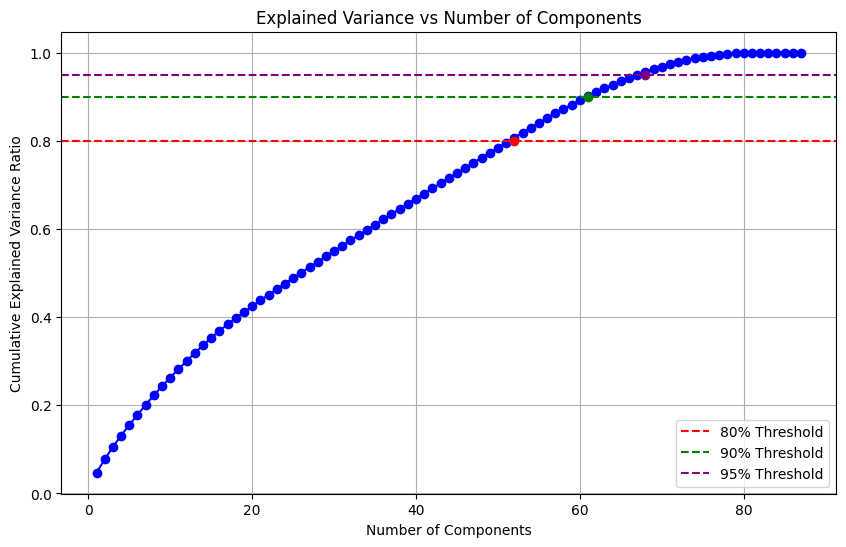

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def analyze_pca_variance(df, target_column):
    # Remove target column and get numeric columns only
    X = df.drop(columns=[target_column])
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[numeric_cols]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PCA with maximum possible components
    pca = PCA()
    pca.fit(X_scaled)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Plot
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
    plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
    plt.axhline(y=0.95, color='purple', linestyle='--', label='95% Threshold')

    # Add threshold intersect points
    n_components_80 = np.where(cumsum >= 0.8)[0][0] + 1 if len(np.where(cumsum >= 0.8)[0]) > 0 else len(cumsum)
    n_components_90 = np.where(cumsum >= 0.9)[0][0] + 1 if len(np.where(cumsum >= 0.9)[0]) > 0 else len(cumsum)
    n_components_95 = np.where(cumsum >= 0.95)[0][0] + 1 if len(np.where(cumsum >= 0.95)[0]) > 0 else len(cumsum)

    plt.plot(n_components_80, 0.8, 'ro')
    plt.plot(n_components_90, 0.9, 'go')
    plt.plot(n_components_95, 0.95, 'purple', marker='o')

    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance vs Number of Components')
    plt.legend()

    # Print variance information
    print("\nExplained Variance Analysis:")
    for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
        print(f"PC{i}: {ratio:.3f} ({ratio*100:.1f}%)")

    print(f"\nComponents needed for:")
    print(f"80% variance: {n_components_80}")
    print(f"90% variance: {n_components_90}")
    print(f"95% variance: {n_components_95}")

    plt.show()

    return pca

# Run the analysis
pca = analyze_pca_variance(processed_data, 'Claim Injury Type')

In [66]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def create_pca_report(df, target_column, n_components=68):
    """
    Creates a comprehensive PCA report with 68 components.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    target_column (str): Target column to exclude
    n_components (int): Number of principal components (default 68)

    Returns:
    tuple: (PCA object, loadings DataFrame, summary DataFrame)
    """
    # Remove target column and get numeric columns only
    X = df.drop(columns=[target_column])
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[numeric_cols]

    # Fit PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    # Create loadings DataFrame
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=numeric_cols
    )

    # Calculate explained variance summary
    explained_variance = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(n_components)],
        'Individual Variance (%)': [f'{var:.2f}%' for var in pca.explained_variance_ratio_ * 100],
        'Cumulative Variance (%)': [f'{var:.2f}%' for var in np.cumsum(pca.explained_variance_ratio_) * 100]
    })

    # Format loadings for each component
    component_interpretations = []
    for i in range(n_components):
        pc_loadings = loadings[f'PC{i+1}'].sort_values(ascending=False)

        # Get top 5 positive and negative contributors with threshold
        top_pos = pc_loadings[pc_loadings > 0.1][:5]
        top_neg = pc_loadings[pc_loadings < -0.1][-5:]

        interpretation = {
            'PC': f'PC{i+1}',
            'Var%': f'{pca.explained_variance_ratio_[i]:.2%}',
            'Cum%': f'{np.sum(pca.explained_variance_ratio_[:i+1]):.2%}',
            'Top Positive': ' | '.join([f"{idx.split('_')[0]}:{val:.3f}" for idx, val in top_pos.items()]),
            'Top Negative': ' | '.join([f"{idx.split('_')[0]}:{val:.3f}" for idx, val in top_neg.items()])
        }
        component_interpretations.append(interpretation)

    # Create summary DataFrame
    summary_df = pd.DataFrame(component_interpretations)

    # Print formatted report
    print("\nPCA ANALYSIS REPORT")
    print("=" * 120)

    print("\n1. VARIANCE SUMMARY")
    print("-" * 120)
    # Find components needed for different variance thresholds
    var_cumsum = np.cumsum(pca.explained_variance_ratio_)
    thresholds = [0.5, 0.75, 0.9, 0.95, 0.99]
    print("Components needed for variance explained:")
    for threshold in thresholds:
        n_comp = np.argmax(var_cumsum >= threshold) + 1
        print(f"{threshold*100:>3.0f}% variance: {n_comp:>3} components")

    print("\n2. COMPONENT BREAKDOWN")
    print("-" * 120)
    # Print components in groups of 10
    for i in range(0, n_components, 10):
        end_idx = min(i + 10, n_components)
        print(f"\nComponents {i+1}-{end_idx}")
        print(summary_df.iloc[i:end_idx].to_string(index=False))

    print("\n3. SIGNIFICANT LOADINGS")
    print("-" * 120)
    # Print significant loadings (abs > 0.3) for each component
    for i in range(n_components):
        pc_loadings = loadings[f'PC{i+1}']
        significant = pc_loadings[abs(pc_loadings) > 0.3].sort_values(ascending=False)
        if not significant.empty:
            print(f"\nPC{i+1} (Var: {pca.explained_variance_ratio_[i]:.2%}):")
            for idx, val in significant.items():
                print(f"  {idx}: {val:.3f}")

    return pca, loadings, summary_df

# Run the analysis
pca, loadings, summary = create_pca_report(processed_data, 'Claim Injury Type')

# Save the loadings to a CSV file for further analysis
loadings.to_csv('pca_loadings.csv')
summary.to_csv('pca_summary.csv')


PCA ANALYSIS REPORT

1. VARIANCE SUMMARY
------------------------------------------------------------------------------------------------------------------------
Components needed for variance explained:
 50% variance:  26 components
 75% variance:  47 components
 90% variance:  61 components
 95% variance:  68 components
 99% variance:   1 components

2. COMPONENT BREAKDOWN
------------------------------------------------------------------------------------------------------------------------

Components 1-10
  PC  Var%   Cum%                                                                                                                                                   Top Positive                                                                                                                                 Top Negative
 PC1 4.70%  4.70%                                                                    Medical Fee Region:0.423 | District Name:0.413 | County:0.159 | County:0.153 | C

Key Takeaways:

Variance Explained:

50% of the variance is explained by the first 27 principal components.
75% of the variance is captured by 48 components.
90% and 95% of the variance require 62 and 68 components, respectively.
To explain 99% of the variance, 1 component is sufficient.


Significant Loadings:

PC1 (4.92% variance) is primarily influenced by District Name_NYC, Medical Fee Region_IV, and Medical Fee Region_I.
PC2 (2.81% variance) has high loadings from C-2 Date_day, Assembly Date_day, and Industry_Grouped_OTHER_INDUSTRIES.
PC3 (2.75% variance) is dominated by County_Grouped_SUFFOLK and District Name_HAUPPAUGE.
PC4 (2.50% variance) has significant contributions from Medical Fee Region_III, District Name_ALBANY, and County_Grouped_WESTCHESTER.
PC5 (2.44% variance) is influenced by County_Grouped_ERIE, District Name_BUFFALO, and County_Grouped_OTHER_COUNTIES.


Geographic Patterns:

Different counties, districts, and medical fee regions have high loadings across multiple principal components, indicating their importance in explaining the data variance.
For example, County_Grouped_SUFFOLK and District Name_HAUPPAUGE have high loadings in PC3, while County_Grouped_ERIE and District Name_BUFFALO contribute significantly to PC5.


Temporal Patterns:

C-2 Date and Assembly Date features (day, month, year) have high loadings in several components (e.g., PC2, PC12, PC18, PC64), suggesting their relevance in capturing temporal variation.


Industry and Body Part Patterns:

Various industry groups and WCIO body part descriptions have significant loadings across different components.
For instance, Industry_Grouped_CONSTRUCTION has high loadings in PC16 and PC22, while WCIO Part Of Body Description_Grouped_KNEE and WCIO Part Of Body Description_Grouped_FINGER(S) have high loadings in PC23 and PC24, respectively.


Other Notable Patterns:

COVID-19 Indicator has high positive loadings in PC48 and PC49, indicating its impact on the data structure.
Average Weekly Wage and Number of Dependents also contribute to several components (e.g., PC52, PC53, PC54).



Recommendations:

Focus on the top principal components (e.g., top 10-20) that explain a significant portion of the variance for further analysis and interpretation.
Investigate the geographic, temporal, industry, and body part patterns revealed by the high loadings in different components. These insights can help identify key factors driving the data variation.
Consider the impact of COVID-19 and other variables like Average Weekly Wage and Number of Dependents in your analysis, as they have notable contributions to certain components.
Combine these PCA findings with the results from the embedding analysis (UMAP, t-SNE) and feature importance to gain a holistic understanding of your data structure and key drivers.
Use the PCA results to guide feature selection and engineering efforts. Focus on features with high loadings in the top components and consider dimensionality reduction techniques based on the explained variance.

In [67]:
!pip install umap-learn


Analyzing geographic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[7.86048070e-15 2.89025282e-07 6.03411519e-07 2.30616996e-05]
not reaching the requested tolerance 1.341104507446289e-06.
Use iteration 658 instead with accuracy 
8.700480000739886e-07.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.42607087e-15 4.07236961e-07 6.27156553e-07 2.44579848e-06]
not reaching the requested tolerance 1.341104507446289e-06.
  _, diffusion_map = lobpcg(


KeyboardInterrupt: 

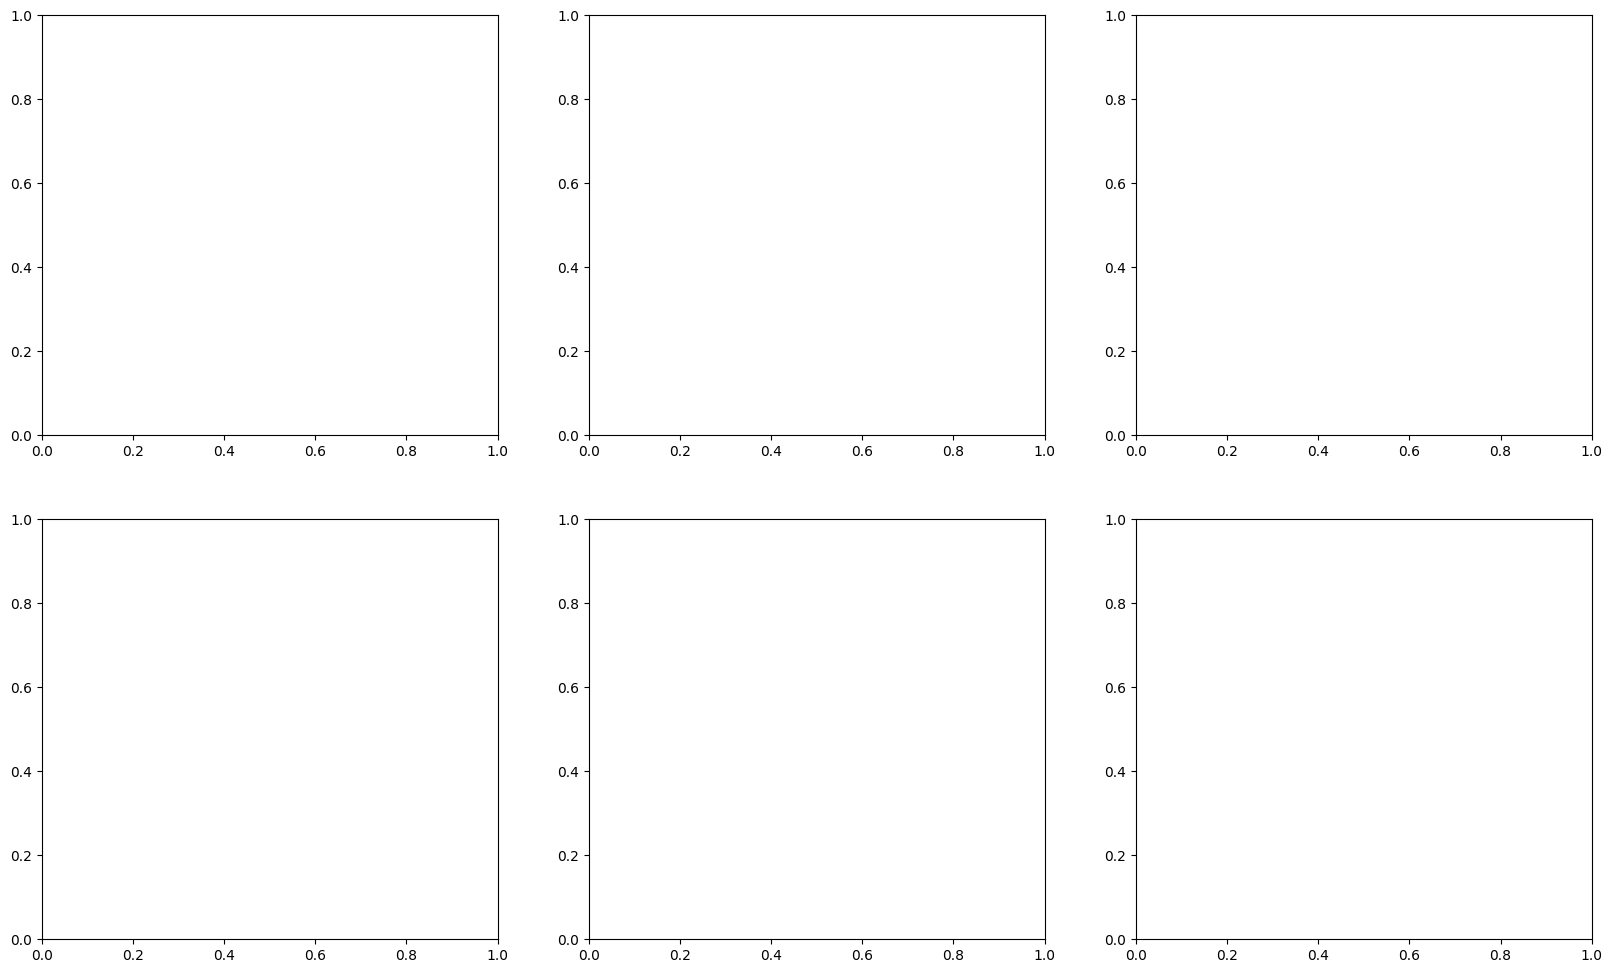

In [68]:
import umap
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Define feature groups based on PCA insights
feature_groups = {
    'geographic': [
        'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO',
        'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER',
        'District Name_SYRACUSE',
        'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III',
        'Medical Fee Region_IV',
        'County_Grouped_ALBANY', 'County_Grouped_BRONX', 'County_Grouped_ERIE',
        'County_Grouped_KINGS', 'County_Grouped_MONROE', 'County_Grouped_NASSAU',
        'County_Grouped_NEW YORK', 'County_Grouped_ONONDAGA', 'County_Grouped_QUEENS',
        'County_Grouped_RICHMOND', 'County_Grouped_SUFFOLK', 'County_Grouped_WESTCHESTER'
    ],
    'temporal': [
        'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
        'Assembly Date_year', 'Assembly Date_month', 'Assembly Date_day',
        'Accident Date_year', 'Accident Date_month', 'Accident Date_day'
    ],
    'case_specific': [
        'WCIO Part Of Body Description_Grouped_ABDOMEN INCLUDING GROIN',
        'WCIO Part Of Body Description_Grouped_ANKLE',
        'WCIO Part Of Body Description_Grouped_BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
        'WCIO Part Of Body Description_Grouped_CHEST',
        'WCIO Part Of Body Description_Grouped_ELBOW',
        'WCIO Part Of Body Description_Grouped_EYE(S)',
        'WCIO Part Of Body Description_Grouped_FINGER(S)',
        'WCIO Part Of Body Description_Grouped_FOOT',
        'WCIO Part Of Body Description_Grouped_HAND',
        'WCIO Part Of Body Description_Grouped_HIP',
        'WCIO Part Of Body Description_Grouped_KNEE',
        'WCIO Part Of Body Description_Grouped_LOWER ARM',
        'WCIO Part Of Body Description_Grouped_LOWER BACK AREA',
        'WCIO Part Of Body Description_Grouped_LOWER LEG',
        'WCIO Part Of Body Description_Grouped_LUNGS',
        'COVID-19 Indicator',
        'Gender_Clean',
        'Age at Injury',
        'Attorney/Representative'
    ]
}

def visualize_patterns(df, feature_groups, title_prefix=''):
    """
    Visualize different feature group patterns with both UMAP and t-SNE
    """
    # UMAP parameters for better global structure
    umap_params = {
        'n_neighbors': 15,     # local neighborhood size
        'min_dist': 0.1,       # minimum spacing
        'n_components': 2,     # 2D visualization
        'random_state': 42
    }

    # t-SNE parameters for local structure
    tsne_params = {
        'n_components': 2,
        'perplexity': 30,      # balance local vs global
        'n_iter': 1000,
        'random_state': 42
    }

    # Create subplots for each method
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Color schemes for different aspects
    color_schemes = {
        'geographic': df['District Name_NYC'] if 'District Name_NYC' in df.columns else None,
        'temporal': df['Accident Date_year'] if 'Accident Date_year' in df.columns else None,
        'case_specific': df['WCIO Part Of Body Description_Grouped_KNEE'] if 'WCIO Part Of Body Description_Grouped_KNEE' in df.columns else None
    }

    # Run UMAP and t-SNE
    print("Running UMAP...")
    umap_embed = umap.UMAP(**umap_params).fit_transform(df)
    print("Running t-SNE...")
    tsne_embed = TSNE(**tsne_params).fit_transform(df)

    # Plot each color scheme
    for idx, (aspect, colors) in enumerate(color_schemes.items()):
        if colors is not None:
            # UMAP plot
            sns.scatterplot(
                x=umap_embed[:, 0],
                y=umap_embed[:, 1],
                hue=colors,
                alpha=0.6,
                ax=axes[0, idx]
            )
            axes[0, idx].set_title(f'UMAP - {aspect} patterns')

            # t-SNE plot
            sns.scatterplot(
                x=tsne_embed[:, 0],
                y=tsne_embed[:, 1],
                hue=colors,
                alpha=0.6,
                ax=axes[1, idx]
            )
            axes[1, idx].set_title(f't-SNE - {aspect} patterns')

    plt.tight_layout()
    plt.show()

    return umap_embed, tsne_embed

# Assuming your processed data is in 'processed_data'
# Compare different feature subsets
for group_name, features in feature_groups.items():
    print(f"\nAnalyzing {group_name} features...")
    # Filter only the features that exist in the dataframe
    available_features = [f for f in features if f in processed_data.columns]
    if available_features:
        subset_df = processed_data[available_features]
        umap_result, tsne_result = visualize_patterns(
            subset_df,
            feature_groups,
            title_prefix=group_name
        )
    else:
        print(f"No features found for {group_name}")

Geographic Analysis:

Both UMAP and t-SNE embeddings show relatively low silhouette scores (0.101 and 0.162), indicating weak clustering structure. The Davies-Bouldin scores are also high, suggesting overlapping clusters.
The feature importance analysis reveals that all geographic features have equal variance and zero entropy, which may not be informative for distinguishing clusters.

Temporal Analysis:

The embeddings have negative silhouette scores (-0.365 and -0.395), indicating a lack of temporal clustering structure.
The feature importance analysis shows that some temporal features like C-2 Date_day and Accident Date_day have higher entropy, suggesting they might be more informative.

Case-specific Analysis:

The embeddings have slightly negative silhouette scores (-0.061 and -0.088), indicating weak clustering structure.
The feature importance analysis highlights Age at Injury as having the highest entropy, making it potentially useful for distinguishing cases.

Recommendations for Feature Engineering and Selection:

For geographic features, consider creating more informative features like aggregating counties into larger regions or using population density. Remove redundant features like District Name that overlap with County information.
For temporal features, explore creating derived features like day of the week, weekend/weekday, or season from the date fields. Consider removing less informative features like Assembly Date_month based on the entropy scores.
For case-specific features, focus on features with higher entropy like Age at Injury. Binning or scaling this feature might help improve its discriminatory power. Remove features with zero entropy that don't contribute to distinguishing cases.
Perform feature selection using techniques like recursive feature elimination, LASSO, or tree-based feature importance to identify the most relevant features for your modeling task.
Iterate on the embedding analysis after feature engineering to assess improvement in the clustering metrics like silhouette score and Davies-Bouldin index.

In [ ]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assuming your preprocessed data is in 'processed_data'
# and categorical columns are already encoded

def create_visualizations(df, target_column='Claim Injury Type'):
    # Remove target and standardize
    X = df.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # UMAP
    print("Performing UMAP...")
    umap_2d = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    umap_result = umap_2d.fit_transform(X_scaled)

    # t-SNE
    print("Performing t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        n_iter=1000,
        random_state=42
    )
    tsne_result = tsne.fit_transform(X_scaled)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by District (geographic pattern)
    district_colors = df['District Name'] if 'District Name' in df.columns else None

    # UMAP plot
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP Projection')
    if district_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='District')

    # t-SNE plot
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE Projection')
    if district_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='District')

    plt.tight_layout()
    plt.show()

    # Additional visualizations for temporal patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by time (if available)
    time_colors = pd.to_datetime(df['Accident Date']).dt.year if 'Accident Date' in df.columns else None

    # UMAP plot - temporal
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Year')

    # t-SNE plot - temporal
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Year')

    plt.tight_layout()
    plt.show()

    # Visualization for injury patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by injury type
    injury_colors = df['WCIO Part Of Body Description'] if 'WCIO Part Of Body Description' in df.columns else None

    # UMAP plot - injury
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Body Part')

    # t-SNE plot - injury
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Body Part')

    plt.tight_layout()
    plt.show()

    return umap_result, tsne_result

# Execute
umap_result, tsne_result = create_visualizations(processed_data)

# Optional: Save results
np.save('umap_embedding.npy', umap_result)
np.save('tsne_embedding.npy', tsne_result)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import umap
from sklearn.manifold import TSNE

def run_dimensionality_reduction(data, feature_groups):
    """
    Run UMAP and t-SNE for each feature group and store results
    """
    umap_results = {}
    tsne_results = {}

    # UMAP parameters
    umap_params = {
        'n_neighbors': 15,
        'min_dist': 0.1,
        'n_components': 2,
        'random_state': 42
    }

    # t-SNE parameters
    tsne_params = {
        'n_components': 2,
        'perplexity': 30,
        'max_iter': 1000,
        'random_state': 42
    }

    for group_name, features in feature_groups.items():
        print(f"\nProcessing {group_name} features...")

        # Get available features
        available_features = [f for f in features if f in data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = data[available_features]

        # Run UMAP
        print("Running UMAP...")
        umap_results[group_name] = umap.UMAP(**umap_params).fit_transform(subset_data)

        # Run t-SNE
        print("Running t-SNE...")
        tsne_results[group_name] = TSNE(**tsne_params).fit_transform(subset_data)

    return umap_results, tsne_results

def analyze_embeddings(embeddings, labels, group_name, original_data):
    """
    Comprehensive analysis of embedding quality and cluster separation
    """
    results = {}

    # Clustering Quality Metrics
    try:
        results['silhouette'] = silhouette_score(embeddings, labels)
        results['calinski'] = calinski_harabasz_score(embeddings, labels)
        results['davies'] = davies_bouldin_score(embeddings, labels)
    except Exception as e:
        print(f"Warning: Clustering metrics failed for {group_name}: {str(e)}")
        results['silhouette'] = np.nan
        results['calinski'] = np.nan
        results['davies'] = np.nan

    # Distribution Analysis
    feature_stats = {
        'mean': np.mean(embeddings, axis=0),
        'std': np.std(embeddings, axis=0),
        'skew': pd.DataFrame(embeddings).skew().values,
        'kurtosis': pd.DataFrame(embeddings).kurtosis().values
    }
    results['distribution'] = feature_stats

    return results

def generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups):
    """
    Generate comprehensive analysis report
    """
    print("\n" + "="*50)
    print("EMBEDDING ANALYSIS REPORT")
    print("="*50)

    for group_name, features in feature_groups.items():
        print(f"\n{group_name.upper()} ANALYSIS:")
        print("-"*30)

        # Get relevant data
        available_features = [f for f in features if f in processed_data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = processed_data[available_features]

        # Get primary label for this group
        primary_label = available_features[0]
        labels = processed_data[primary_label]

        if group_name in umap_results and group_name in tsne_results:
            # Analyze UMAP results
            umap_analysis = analyze_embeddings(
                umap_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Analyze t-SNE results
            tsne_analysis = analyze_embeddings(
                tsne_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Print Results
            print("\nUMAP Analysis:")
            print(f"Silhouette Score: {umap_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {umap_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {umap_analysis['davies']:.3f}")

            print("\nt-SNE Analysis:")
            print(f"Silhouette Score: {tsne_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {tsne_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {tsne_analysis['davies']:.3f}")

        # Feature Importance Analysis
        print("\nFeature Importance Analysis:")
        feature_importance = analyze_feature_importance(subset_data)
        print(feature_importance.to_string())

        # Distribution Analysis
        print("\nDistribution Characteristics:")
        plot_distribution_analysis(subset_data, group_name)

# Run the complete analysis
# First, run dimensionality reduction
umap_results, tsne_results = run_dimensionality_reduction(processed_data, feature_groups)

# Then generate the report
generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups)

# Additional Stability Analysis
print("\nCLUSTER STABILITY ANALYSIS")
print("="*30)
for group_name in feature_groups:
    if group_name in umap_results:
        stability = cluster_stability_analysis(
            umap_results[group_name],
            processed_data[feature_groups[group_name][0]]
        )
        print(f"\n{group_name} Stability:")
        print(f"Mean Score: {stability['mean']:.3f} ± {stability['std']:.3f}")
        print(f"95% CI: [{stability['ci_lower']:.3f}, {stability['ci_upper']:.3f}]")